# Multisensor rail detection in automatic train operations - Exploratory data analysis

Attila Kovacs
25.9.2023

## Introduction

In this notebook, we will perform the exploratory data analysis for the multi-sensor dataset provided by Deutsch Bahn / Digitale Schiene Deutschland (https://digitale-schiene-deutschland.de/en/news/OSDaR23-multi-sensor-data-set-for-machine-learning).
The goal is to get a deep understanding of characteristics of the datasets and how it can be best applied to solve the rail detection problem.



## Requiered packages

In [1]:
#from config import settings
import os
from glob import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import re
import cv2
from easyimages import EasyImage, EasyImageList, bbox
from easyimages.easyimages import CTX

from utils import print_image, parse_input, print_map, calculate_brightness

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline


## Load metadata

The total numner of annotation IDs in the dataset is 236.467.
Extracting this number is important in order to check against the dataframe that is being used for analysis.

In [2]:
number_labels_uid = 0
for d in os.listdir("./orig_data/DB/"):
    file_name = glob(f"./orig_data/DB/{d}/*.json")[0]
    with open(file_name) as f:
        raw = f.read()
        number_labels_uid += len(re.findall("uid", raw))
number_labels_uid

236467

Next, we load the actual data that we want to use for the exploration.
There is one metadata file for each sub-dataset comprising the required information about the sensors, objects, and annotations.

In [3]:
df = parse_input()

./orig_data/DB/10_station_suelldorf_10.1\10_station_suelldorf_10.1_labels.json
./orig_data/DB/11_main_station_11.1\11_main_station_11.1_labels.json
./orig_data/DB/12_vegetation_steady_12.1\12_vegetation_steady_12.1_labels.json
./orig_data/DB/13_station_ohlsdorf_13.1\13_station_ohlsdorf_13.1_labels.json
./orig_data/DB/14_signals_station_14.1\14_signals_station_14.1_labels.json
./orig_data/DB/14_signals_station_14.2\14_signals_station_14.2_labels.json
./orig_data/DB/14_signals_station_14.3\14_signals_station_14.3_labels.json
./orig_data/DB/15_construction_vehicle_15.1\15_construction_vehicle_15.1_labels.json
./orig_data/DB/16_under_bridge_16.1\16_under_bridge_16.1_labels.json
./orig_data/DB/17_signal_bridge_17.1\17_signal_bridge_17.1_labels.json
./orig_data/DB/18_vegetation_switch_18.1\18_vegetation_switch_18.1_labels.json
./orig_data/DB/19_vegetation_curve_19.1\19_vegetation_curve_19.1_labels.json
./orig_data/DB/1_calibration_1.1\1_calibration_1.1_labels.json
./orig_data/DB/1_calibratio

An example of the dataframe including the used columns is given below.

In [4]:
df.columns

Index(['longitude', 'latitude', 'tag', 'type', 'object_uid', 'name',
       'label_uid', 'sensor', 'height', 'width', 'path', 'dataset',
       'timestamp', 'label_type', 'closed', 'val', 'occlusion', 'railSide'],
      dtype='object')

* longitude: GPS coordiante
* latitude: GPS coordinate
* tag: sub-dataset
* type: object type or class
* object_uid: ID of object (same object can be detected in different images)
* name: combination of sensor, annotation type, and type
* label_uid: ID of label or annotation
* sensor: type of sensor
* height: height of image
* width: width of image
* path: path to image
* dataset: is equal to tag, but is kept as both names are used in the original data
* timestamp 
* label_type: there are different annotation types (e.g., polyline, bounding box, polygon)
* closed: wheter or not polyline is closed
* val: value of polyline
* occlusion: visibility of object in image
* railSide: indicates whether annotation refers to left or right side of the track

In [5]:
df.head()

longitude   latitude                        tag    type  \
0   9.797191  53.581087  10_station_suelldorf_10.1  signal   
1   9.797191  53.581087  10_station_suelldorf_10.1  signal   
2   9.797191  53.581087  10_station_suelldorf_10.1  signal   
3   9.797191  53.581087  10_station_suelldorf_10.1  signal   
4   9.797191  53.581087  10_station_suelldorf_10.1  signal   

                             object_uid                                name  \
0  02ca6d43-1f4a-4812-a145-f409be84f405           ir_center__poly2d__signal   
1  02ca6d43-1f4a-4812-a145-f409be84f405          rgb_center__poly2d__signal   
2  02ca6d43-1f4a-4812-a145-f409be84f405  rgb_highres_center__poly2d__signal   
3  02ca6d43-1f4a-4812-a145-f409be84f405               lidar__cuboid__signal   
4  02ca6d43-1f4a-4812-a145-f409be84f405                  lidar__vec__signal   

                              label_uid              sensor  height  width  \
0  18969f90-f21d-4fbb-af9d-de98b6d4a966           ir_center     480    640   
1  5adc793e-a3ea-4a79-a994-ccfb505e0c40          rgb_center    1600   2464   
2  05d901a1-cde6-4a4b-9730-71b6033f4ac8  rgb_highres_center    2504   4112   
3  9f432542-0f6b-43f0-a98f-3a7916a02475               lidar    3008   4112   
4  2fb1acff-900a-4d13-b6f6-506dae68f5fe               lidar    3008   4112   

                                                path  \
0  10_station_suelldorf_10.1/ir_center/216_163170...   
1  10_station_suelldorf_10.1/rgb_center/216_16317...   
2  10_station_suelldorf_10.1/rgb_highres_center/2...   
3  10_station_suelldorf_10.1/lidar/216_1631703820...   
4  10_station_suelldorf_10.1/lidar/216_1631703820...   

                     dataset             timestamp label_type closed  val  \
0  10_station_suelldorf_10.1  1631703820.699805000     poly2d    NaN  NaN   
1  10_station_suelldorf_10.1  1631703820.699805000     poly2d    NaN  NaN   
2  10_station_suelldorf_10.1  1631703820.699805000     poly2d    NaN  NaN   
3  10_station_suelldorf_10.1  1631703820.699805000     cuboid    NaN  NaN   
4  10_station_suelldorf_10.1  1631703820.699805000        vec    NaN  NaN   

  occlusion railSide  
0       NaN      NaN  
1       NaN      NaN  
2       NaN      NaN  
3       NaN      NaN  
4       NaN      NaN

## Analyize whole dataset

The images have been generated between '2021-09-09 08:28:22' and  '2021-09-15 15:25:53'.
That is, we cannot expect to observe seasonal differences (e.g., snow)


In [6]:
# earliest record
datetime.utcfromtimestamp(float(df.timestamp.min())).strftime("%Y-%m-%d %H:%M:%S")

'2021-09-09 08:28:22'

In [7]:
# latest record
datetime.utcfromtimestamp(float(df.timestamp.max())).strftime("%Y-%m-%d %H:%M:%S")

'2021-09-15 15:25:53'

### Images

The number of images in the dataset is 13.952.

In [8]:
# number of images
len(df.path.unique())

13952

The number of (labeled) images per sensor is given blow.

sensor
ir_right               966
rgb_right             1024
rgb_highres_right     1034
ir_left               1146
rgb_highres_left      1308
rgb_left              1314
radar                 1421
lidar                 1434
ir_center             1435
rgb_center            1435
rgb_highres_center    1435
Name: path, dtype: int64

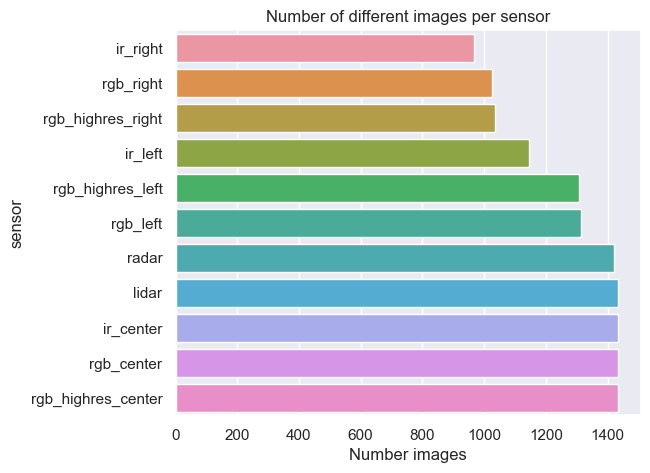

In [11]:
# labeled images per sensor
sns.set(rc={"figure.figsize": (6, 5)})
df_temp = df.groupby(["sensor"])["path"].nunique().sort_values()
ax = sns.barplot(y=df_temp.index, x=df_temp).set(
    title="Number of different images per sensor", xlabel="Number images"
)
df_temp

We also give the number of images that display a given class

type
person               9632
track                8855
signal               6916
signal_pole          5735
train                5350
catenary_pole        4351
road_vehicle         3724
buffer_stop          2843
switch               1952
bicycle              1398
crowd                1196
animal               1179
group_of_bicycles     625
flame                 410
transition            388
smoke                 188
signal_bridge         132
wagons                110
drag_shoe              59
motorcycle              9
Name: count, dtype: int64

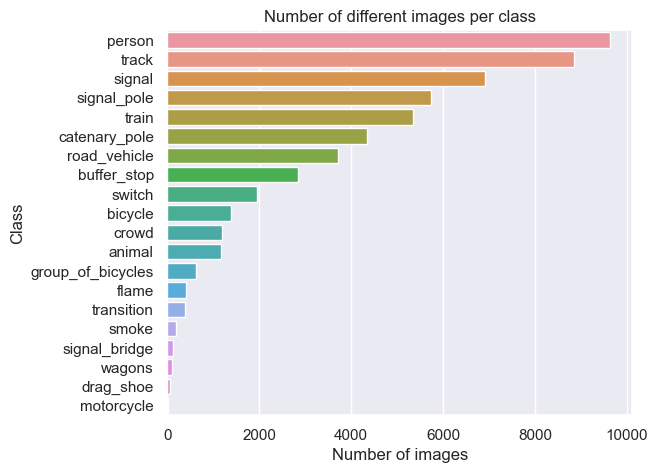

In [12]:
# images per label
df_temp = df[["type", "path"]].drop_duplicates()["type"].value_counts()
sns.barplot(y=df_temp.index, x=df_temp).set(
    title="Number of different images per class",
    xlabel="Number of images",
    ylabel="Class",
)
df_temp

### Annotations

The number of annotations matches the number of unique IDs in the input file. In total, there are 236.467 annotations.

In [13]:
# number of labels
assert number_labels_uid == len(df)
len(df)

236467

The number of labels depends on the sensor and the orientation. For example, IR cameras pick up less objects than lidar, radar or rgb.
Sensors oriented to the left or right pick up less objects than sensors oriented to the center.

sensor
lidar                 56072
rgb_highres_center    41827
rgb_center            36505
radar                 24290
ir_center             18312
rgb_highres_left      12380
rgb_highres_right     12213
rgb_left              11471
rgb_right              9555
ir_left                7841
ir_right               6001
Name: count, dtype: int64

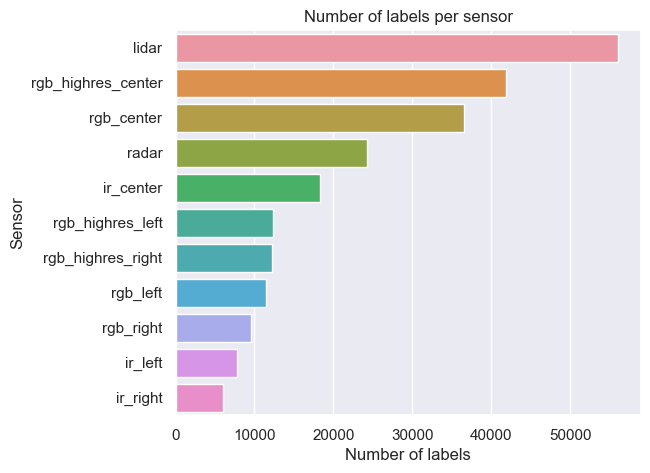

In [14]:
# lables per sensor
df_temp = df["sensor"].value_counts()
sns.barplot(y=df_temp.index, x=df_temp).set(
    title="Number of labels per sensor", xlabel="Number of labels", ylabel="Sensor"
)
df_temp

There is an imbalance in the labeled classes. However, we are not affected by the imbalance as need only the class "track".

type
person               83547
signal               33499
track                33049
catenary_pole        31044
signal_pole          14531
road_vehicle         11994
train                10113
buffer_stop           5284
animal                3811
switch                3351
bicycle               1896
crowd                 1458
transition            1093
group_of_bicycles      644
flame                  410
signal_bridge          332
smoke                  188
wagons                 130
drag_shoe               79
motorcycle              14
Name: count, dtype: int64

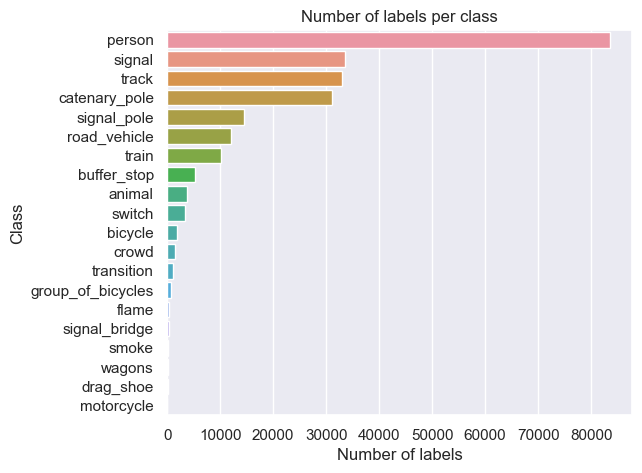

In [15]:
# annotations per class
df_temp = df["type"].value_counts()
sns.barplot(y=df_temp.index, x=df_temp).set(
    title="Number of labels per class", xlabel="Number of labels", ylabel="Class"
)
df_temp

In [16]:
# classes
# sns.set(rc={"figure.figsize": (15, 5)})
# p = sns.countplot(x=df["type"], order=df["type"].value_counts().index)
# p = p.set_xticklabels(p.get_xticklabels(), rotation=90)
# plt.title("Number of annotations per class")
# plt.xlabel("Annotation class")
# plt.show()

## Analize only relevant data (i.e, class = track)

As we are intereseted in identifying tracks only, we filter the dataframe accordingly.

In [17]:
# filter only on relevant data
df = df[(df["type"] == "track") & (df["label_type"] == "poly2d")]
df["poly2d"] = df.val.apply(lambda x: np.array(np.reshape(x, (-1, 2)), dtype=np.int32))

There are 27.386 annotations in 7.421 images left.

In [18]:
# number of labels
len(df)

27386

In [19]:
# number of images
len(df.path.unique())

7421

We can see that there are less images showing tracks when sensors are oriented to the left or to the right comapared to sensors oriented to the front.

sensor
ir_center             1435
rgb_center            1435
rgb_highres_center    1435
rgb_highres_right      805
ir_right               574
rgb_right              565
ir_left                398
rgb_highres_left       397
rgb_left               377
Name: count, dtype: int64

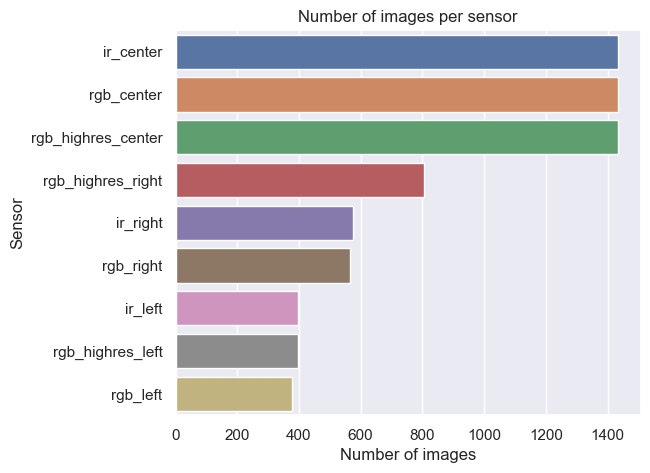

In [20]:
df_temp = df[["sensor", "path"]].drop_duplicates()["sensor"].value_counts()
sns.barplot(y=df_temp.index, x=df_temp).set(
    title="Number of images per sensor", xlabel="Number of images", ylabel="Sensor"
)
df_temp

The number of labels per sensor is given below. 

sensor
rgb_highres_center    6894
rgb_center            6595
ir_center             4736
rgb_highres_right     2230
ir_right              1767
rgb_right             1592
ir_left               1248
rgb_highres_left      1176
rgb_left              1148
Name: count, dtype: int64

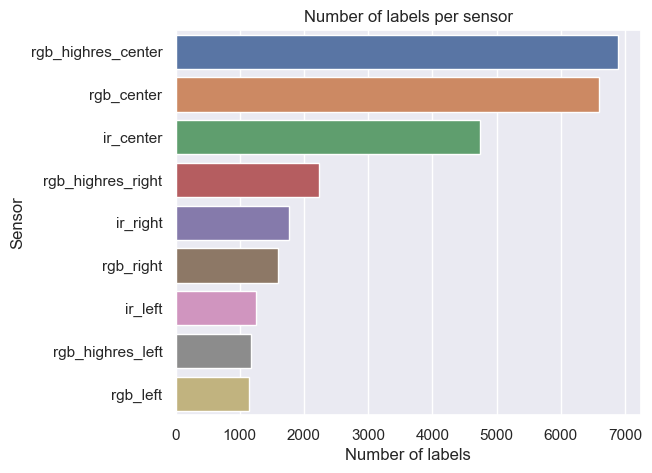

In [21]:
# lables per sensor
df_temp = df["sensor"].value_counts()
sns.barplot(y=df_temp.index, x=df_temp).set(
    title="Number of labels per sensor", xlabel="Number of labels", ylabel="Sensor"
)
df_temp

### Analyzing the aspect of the images

In [22]:
df_aspect = df[["path", "width", "height", "sensor"]].drop_duplicates()
df_aspect["aspect_ratio"] = df_aspect.apply(lambda x: x.width / x.height, axis=1)
df_aspect.head()

path  width  height  \
28   10_station_suelldorf_10.1/ir_center/216_163170...    640     480   
30   10_station_suelldorf_10.1/rgb_center/216_16317...   2464    1600   
32   10_station_suelldorf_10.1/rgb_highres_center/2...   4112    2504   
176  10_station_suelldorf_10.1/ir_center/217_163170...    640     480   
178  10_station_suelldorf_10.1/rgb_center/217_16317...   2464    1600   

                 sensor  aspect_ratio  
28            ir_center      1.333333  
30           rgb_center      1.540000  
32   rgb_highres_center      1.642173  
176           ir_center      1.333333  
178          rgb_center      1.540000

The images in the dataset come in three different aspect rations.

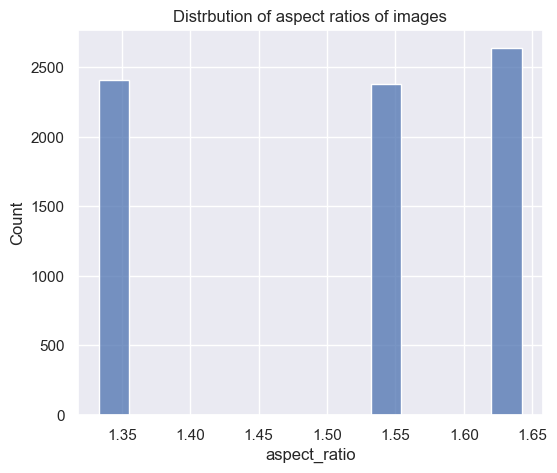

In [23]:
_ = sns.histplot(df_aspect.aspect_ratio).set(
    title="Distrbution of aspect ratios of images"
)

The sensors have different aspect ratios. The high resolution cameras provide the widest images, where infrarad cameras are the narrowest.

[Text(0.5, 1.0, 'Aspect ratios of sensors')]

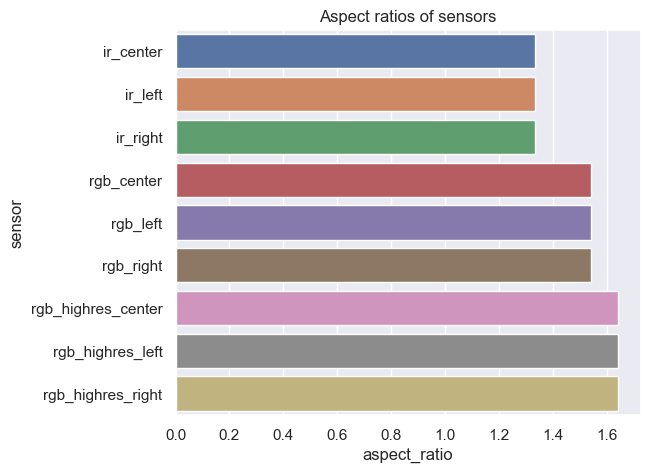

In [24]:
sns.barplot(df_aspect.sort_values("aspect_ratio"), x="aspect_ratio", y="sensor").set(
    title="Aspect ratios of sensors"
)

The respecive width and height are given below.

In [25]:
df[["width", "height", "sensor"]].drop_duplicates().sort_values("width")

width  height              sensor
28       640     480           ir_center
2809     640     480            ir_right
11119    640     480             ir_left
30      2464    1600          rgb_center
2813    2464    1600           rgb_right
11123   2464    1600            rgb_left
32      4112    2504  rgb_highres_center
2817    4112    2504   rgb_highres_right
11127   4112    2504    rgb_highres_left

### Labels per image

In the historgram below, we visualise the number of labels (i.e., single tracks) in the images.
As expected rail tracks come in pair (left side and right side). Nevertheless, there is also a low number of images showing only one part of the rail tracks.

[Text(0.5, 1.0, 'Histogram of classes per image')]

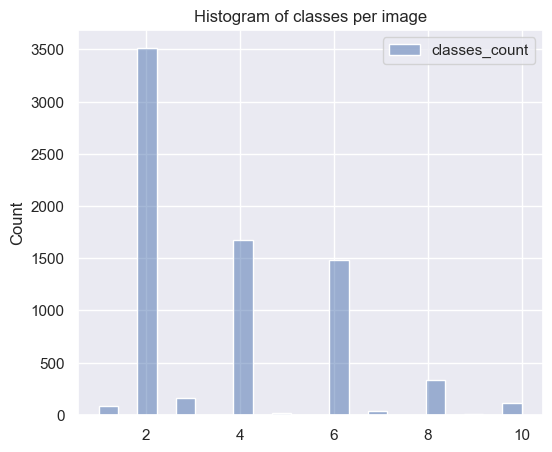

In [26]:
df_classes_count = df.groupby(["path"], as_index=False).agg(
    classes_count=("label_uid", lambda x: x.nunique())
)
sns.histplot(df_classes_count).set(title="Histogram of classes per image")

### Local distribution

The videos/images have all be generated in the area of Hamburg. By zooming in, we can see the movement of the vehicle during taking the video.

In [27]:
print_map(df)

### Temporal distribution

As all images/videos have been taken between 8AM and 17PM, we cannot expect to test the effect of different sensors in the night.

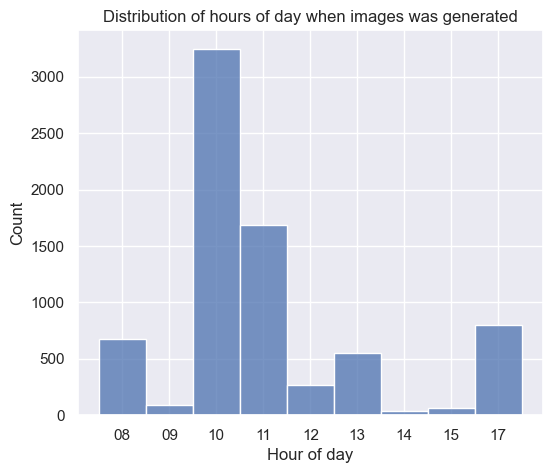

In [28]:
df_temp = (
    df[["path", "timestamp"]]
    .drop_duplicates()
    .apply(
        lambda x: datetime.utcfromtimestamp(float(x.timestamp)).strftime("%H"), axis=1
    )
    .sort_values()
)
_ = sns.histplot(df_temp).set(
    title="Distribution of hours of day when images was generated", xlabel="Hour of day"
)

### Some examples

Next, we visualize some images and plot the annottions in red in order to get a feeling for the images.
There is a wide range of images, e.g. from different sensors, different locations, and different perspectives.

12_vegetation_steady_12.1/rgb_highres_right/009_1631177221.000000022.png


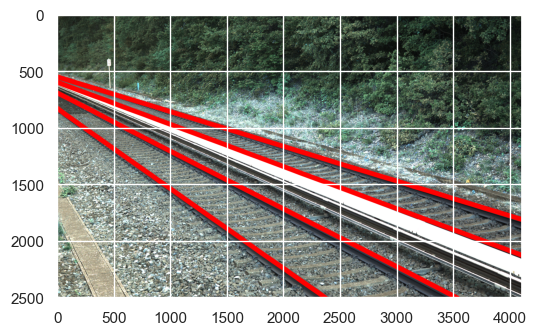

In [29]:
path = df[df.path.str.contains("high")].path.unique()[39]
print_image(df, path, True)

11_main_station_11.1/rgb_highres_center/277_1631531579.800000026.png


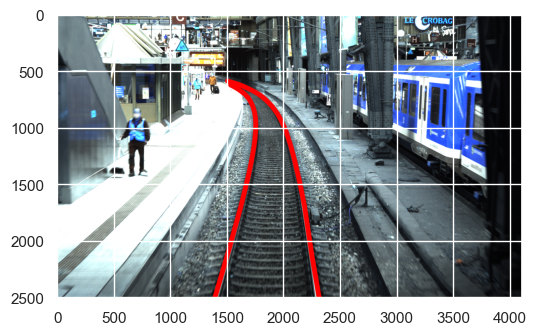

11_main_station_11.1/rgb_highres_center/277_1631531579.800000026.png


In [30]:
path = df.path.unique()[35]
print_image(df, path, True)
print(path)

10_station_suelldorf_10.1/rgb_center/219_1631703821.000000000.png


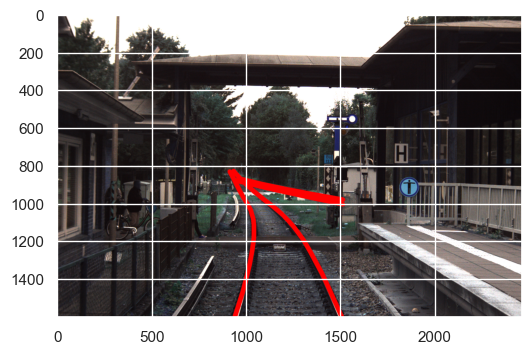

10_station_suelldorf_10.1/rgb_center/219_1631703821.000000000.png


In [31]:
path = df.path.unique()[10]
print_image(df, path, True)
print(path)

12_vegetation_steady_12.1/ir_center/002_1631177220.300465200.png


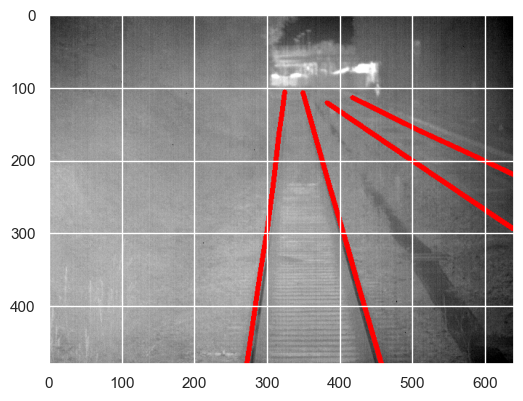

12_vegetation_steady_12.1/ir_center/002_1631177220.300465200.png


In [32]:
path = df[df["sensor"] == "ir_center"].path.unique()[22]
print_image(df, path, True)
print(path)

### Analyze the brightness of the images

In [33]:
%%time
files = glob('./dataframe_dumps/brightness_dump_*')
print(files)
if len(files) > 0:
    df_temp = pd.read_csv(max(files, key=os.path.getmtime))
else:
    df_temp = df[["path", "sensor"]].drop_duplicates()
    df_temp["brightness"] = df_temp.apply(lambda x: calculate_brightness(f"./orig_data/DB/{x.path}"), axis=1)
    brightness_dump = f"./dataframe_dumps/brightness_dump_{datetime.now().strftime('%m-%d-%Y_%H-%M-%S')}.csv"
    df_temp.to_csv(brightness_dump, index=False)

['./dataframe_dumps\\brightness_dump_09-28-2023_09-48-37.csv']
CPU times: total: 0 ns
Wall time: 29 ms


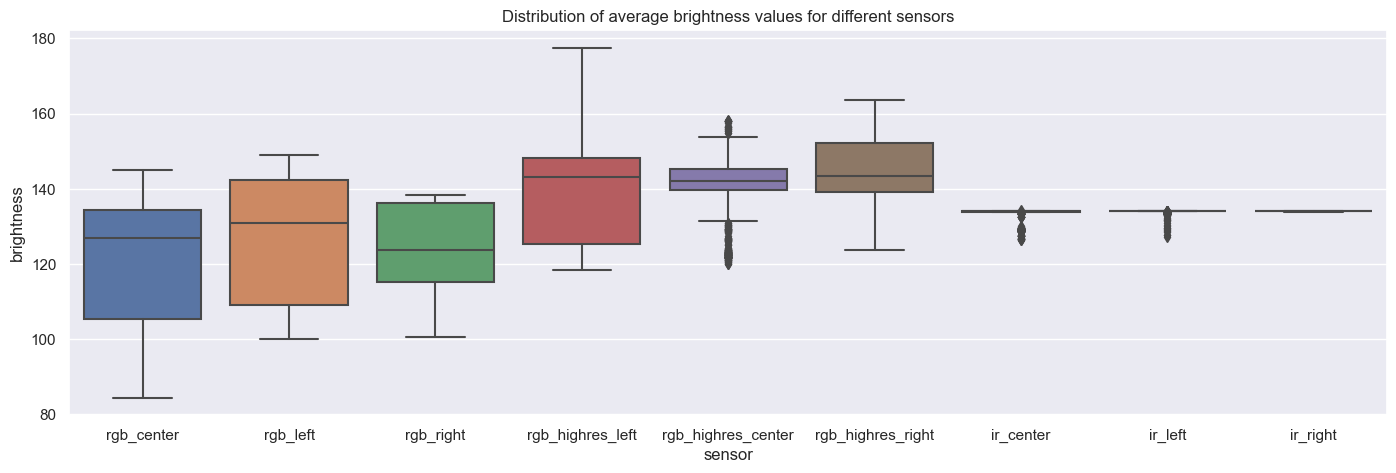

In [38]:
sns.set(rc={"figure.figsize": (17, 5)})
_ = sns.boxplot(
    df_temp[["sensor", "brightness"]].sort_values("brightness"),
    x="sensor",
    y="brightness",
).set(title="Distribution of average brightness values for different sensors")

### Checking the orientation of the tracks in the pictures

In oder to understand which type of shapes are learned by the CNN, we analyze the orientation of the tracks (e.g., vertical, horizontal, diagonal).
Therefore, for each polyline we compare the starting and ending point. A large difference in the x-coordinates but no change in the y-coordinates indicates that the tracks are horizontal in the image; no difference in the x-coordinates but a large difference in the y-coordinates indicates that the tracks are vertical. However, this approach does not state whether the tracks are curved or straight (examples are given below).
The changes in the respective coordinates are scaled between 0 and 1 to account for different image sizes.

The figure below gives the histogram of the x and deviations for each orientation of the sensor.
In the images with a center orientation, it can be seen that most tracks are vertically oriented. In the left and right oriented sensors, we can expect to see tracks that are almost horizontal.
Independently of the sensor, there is a large number of images that show only a small part of the track (see lower left corner of plots).

C:\Users\atkovacs\AppData\Local\Temp\ipykernel_5148\4081980389.py:33: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



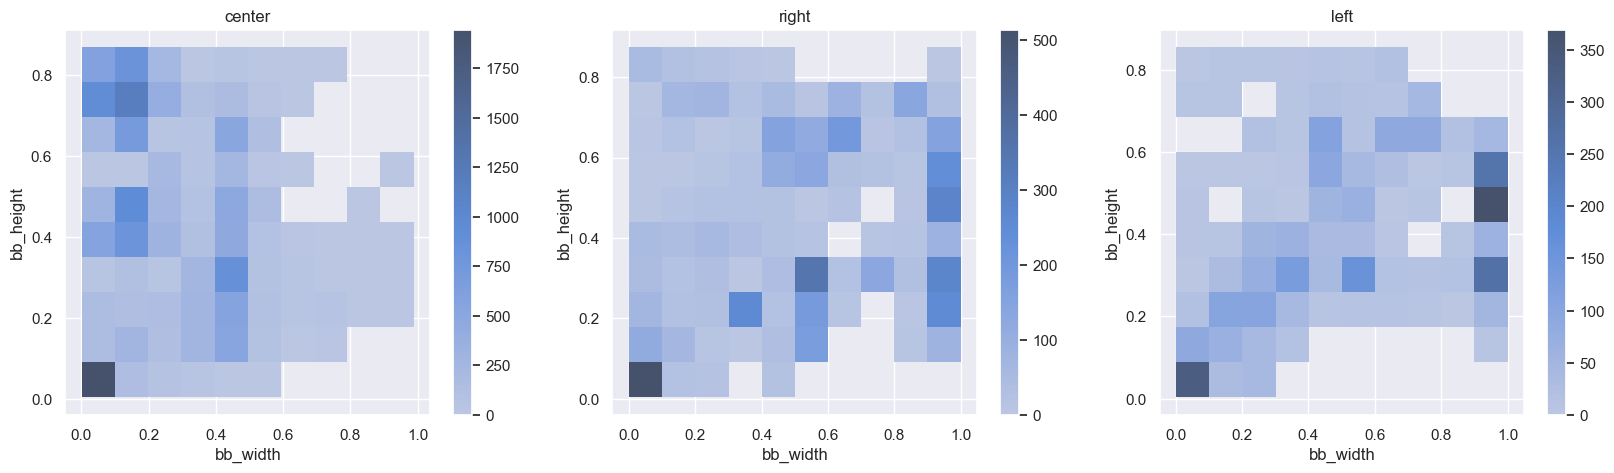

In [39]:
sns.set(rc={"figure.figsize": (20, 5)})

df_temp = df
# select only the orientation of the sensor
df_temp["sensor_short"] = df_temp["sensor"].apply(lambda x: x.split("_")[-1])


df_temp["bb_width"] = df_temp.apply(
    lambda x: (max([i[0] for i in x.poly2d]) - min([i[0] for i in x.poly2d])) / x.width,
    axis=1,
)

df_temp["bb_height"] = df_temp.apply(
    lambda x: (max([i[1] for i in x.poly2d]) - min([i[1] for i in x.poly2d]))
    / x.height,
    axis=1,
)


# plot
number_plots = len(df_temp["sensor_short"].unique())
fig, ax = plt.subplots(1, number_plots)
for idx, s in enumerate(df_temp["sensor_short"].unique()):
    df_plot = df_temp[df_temp["sensor_short"] == s]
    sns.histplot(
        x=df_plot["bb_width"],
        y=df_plot["bb_height"],
        ax=ax[idx],
        cbar=True,
        bins=10,
    ).set(title=s)

fig.show()

#### Examples: small width, large height

The track labels are vertically oriented but might be curved or start end end at the border of the image. 

In [77]:
df_temp = df[["bb_width", "bb_height", "path", "label_uid"]].sort_values(
    ["bb_height", "bb_width"], ascending=[False, True]
)
df_temp.head()

bb_width  bb_height  \
155294  0.083901   0.873403   
155442  0.150535   0.873003   
155603  0.095331   0.870208   
155751  0.156858   0.869808   
155906  0.084874   0.869010   

                                                     path  \
155294  7_approach_underground_station_7.1/rgb_highres...   
155442  7_approach_underground_station_7.1/rgb_highres...   
155603  7_approach_underground_station_7.1/rgb_highres...   
155751  7_approach_underground_station_7.1/rgb_highres...   
155906  7_approach_underground_station_7.1/rgb_highres...   

                                   label_uid  
155294  746f9d75-3e6c-4a59-a7c6-ddfa63507421  
155442  921133c9-933d-45e8-903e-e5040765c28c  
155603  9957be4f-a572-4780-b502-0cc72ae483c9  
155751  61aa72ba-b12d-4b4d-84f5-4d5daa3b70bc  
155906  9d7d3669-faf2-4861-8f31-810d9c0e4842

7_approach_underground_station_7.1/rgb_highres_right/154_1631705118.500000000.png


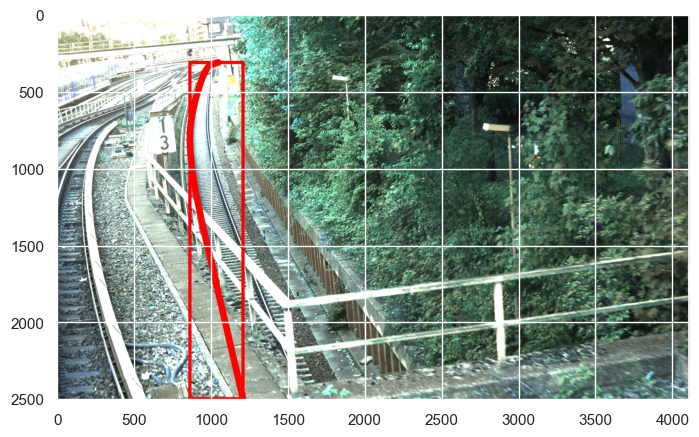

In [78]:
path = df_temp.iloc[0]["path"]
uid = df_temp.iloc[0]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True, True)

10_station_suelldorf_10.1/ir_center/219_1631703821.000464480.png


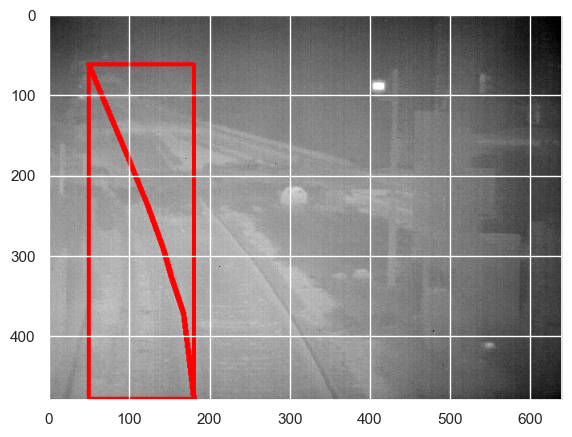

In [79]:
path = df_temp.iloc[5]["path"]
uid = df_temp.iloc[5]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True, True)

#### Examples: small y, large x

The track labels are horizontally oriented. 

In [80]:
df_temp = df[["bb_width", "bb_height", "path", "label_uid"]].sort_values(
    ["bb_width", "bb_height"], ascending=[False, True]
)
df_temp.head()

bb_width  bb_height  \
132194  0.999757   0.220847   
132195  0.999757   0.221645   
132505  0.999757   0.223243   
132817  0.999757   0.223243   
131011  0.999757   0.227636   

                                                     path  \
132194  5_station_bergedorf_5.1/rgb_highres_right/076_...   
132195  5_station_bergedorf_5.1/rgb_highres_right/076_...   
132505  5_station_bergedorf_5.1/rgb_highres_right/077_...   
132817  5_station_bergedorf_5.1/rgb_highres_right/078_...   
131011  5_station_bergedorf_5.1/rgb_highres_right/072_...   

                                   label_uid  
132194  f676f09b-a13b-4bc6-aa1b-82e85c552200  
132195  aa0cbbae-a8fc-4413-8b55-2fab94a79343  
132505  2cd3b2dc-313f-4219-8a2e-218b3a5409f6  
132817  eff822a8-b81f-456e-be42-729ec9702444  
131011  29e10c43-ddf6-4f0c-959e-6bc802358773

5_station_bergedorf_5.1/rgb_highres_right/076_1631529900.700000016.png


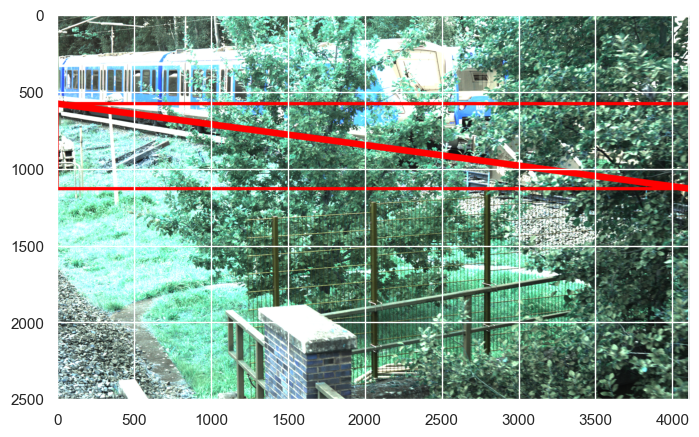

In [81]:
path = df_temp.iloc[0]["path"]
uid = df_temp.iloc[0]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True, True)

16_under_bridge_16.1/rgb_highres_left/447_1631525770.800000027.png


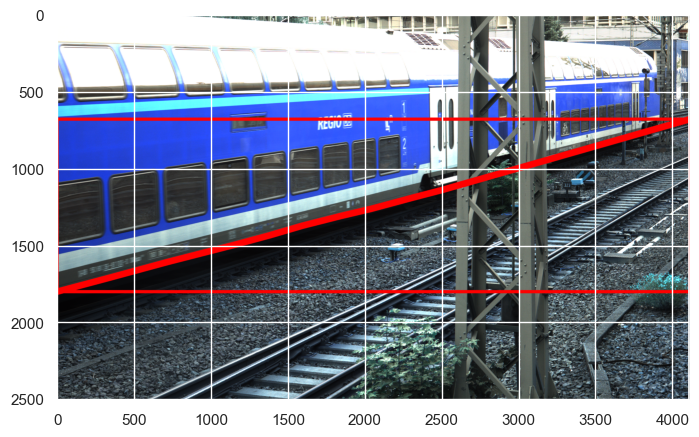

In [82]:
path = df_temp.iloc[120]["path"]
uid = df_temp.iloc[120]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True, True)

#### Examples: small y, small x

Track labels that are very small. 

In [83]:
df_temp = df[["bb_width", "bb_height", "path", "label_uid"]].sort_values(
    ["bb_width", "bb_height"], ascending=[True, True]
)
df_temp.head()

bb_width  bb_height                                               path  \
41710  0.000406   0.003750  1_calibration_1.2/rgb_right/038_1631441717.900...   
41900  0.000406   0.003750  1_calibration_1.2/rgb_right/039_1631441718.000...   
50527  0.000406   0.020000  1_calibration_1.2/rgb_right/085_1631441722.600...   
50715  0.000406   0.026250  1_calibration_1.2/rgb_right/086_1631441722.700...   
50904  0.000406   0.026875  1_calibration_1.2/rgb_right/087_1631441722.800...   

                                  label_uid  
41710  05b9c95b-e5eb-484f-9793-622a474acc8c  
41900  5b14ec2d-33e0-4fae-93f7-9a09e15e1995  
50527  1b3c10df-d69f-459d-b3b8-7be2decd6551  
50715  bdaa0c81-d7c2-40a0-8fb2-934d373c0f7a  
50904  d2ecd14f-b0b4-42b6-b73a-6ca41356f8d6

1_calibration_1.2/rgb_right/038_1631441717.900000016.png


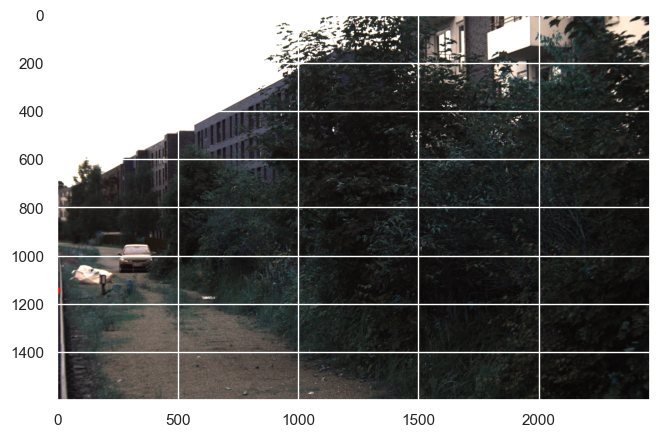

In [84]:
path = df_temp.iloc[0]["path"]
uid = df_temp.iloc[0]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

1_calibration_1.2/rgb_highres_right/023_1631441716.400000002.png


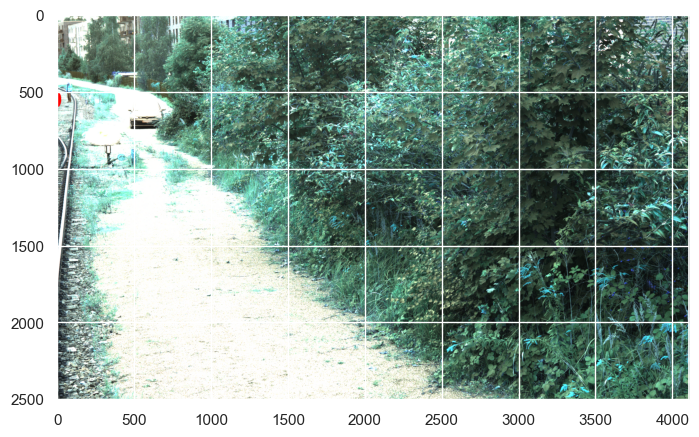

In [85]:
path = df_temp.iloc[10]["path"]
uid = df_temp.iloc[10]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True, True)

#### Examples: large y, large x

The track labels are diagonally oriented. 

In [86]:
df_temp = df[["bb_width", "bb_height", "path", "label_uid"]].sort_values(
    ["bb_width", "bb_height"], ascending=[False, False]
)
df_temp.head()

bb_width  bb_height  \
31303   0.999757   0.732029   
31473   0.999757   0.716454   
31644   0.999757   0.692492   
226618  0.999757   0.685703   
226902  0.999757   0.683706   

                                                     path  \
31303   18_vegetation_switch_18.1/rgb_highres_right/07...   
31473   18_vegetation_switch_18.1/rgb_highres_right/08...   
31644   18_vegetation_switch_18.1/rgb_highres_right/08...   
226618  9_station_ruebenkamp_9.3/rgb_highres_right/219...   
226902  9_station_ruebenkamp_9.3/rgb_highres_right/220...   

                                   label_uid  
31303   ae8d4891-9c7c-45ac-8829-7bca7595bb8b  
31473   ffd603d6-aa01-4177-893b-381a30e64168  
31644   923d1ec0-6265-4ae0-9c6a-53574137f002  
226618  d13d5a6a-c14f-43ff-87bf-5464c701d32c  
226902  f1da21d8-a573-4c08-8835-6e3411141471

18_vegetation_switch_18.1/rgb_highres_right/079_1631625169.000000029.png


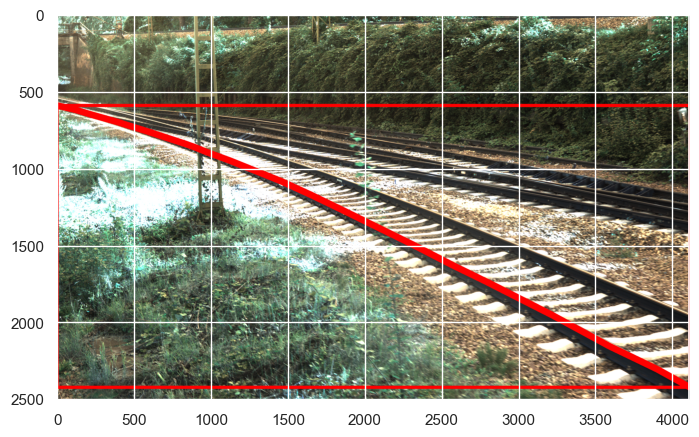

In [87]:
path = df_temp.iloc[0]["path"]
uid = df_temp.iloc[0]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True, True)

14_signals_station_14.3/rgb_highres_left/023_1631450782.400000025.png


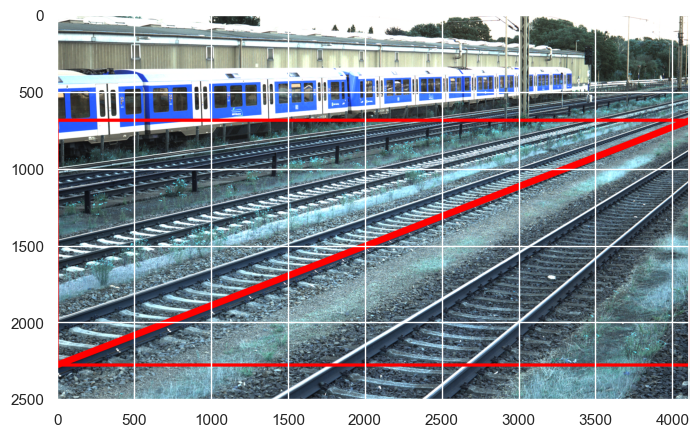

In [88]:
path = df_temp.iloc[20]["path"]
uid = df_temp.iloc[20]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True, True)

### Occulsion

As we have seen above, there are certain labels that are hidden behind e.g. trees or are not fully visible due to a train tarvelling on the track segment.
Here, we analyze the occulsion of the labels.

The major part of the tracks labels is visible. 320 labels have an occlusion factor of 100%.  

occlusion
0-25 %     20069
75-99 %     3083
25-50 %     2502
50-75 %     1412
100 %        320
Name: count, dtype: int64

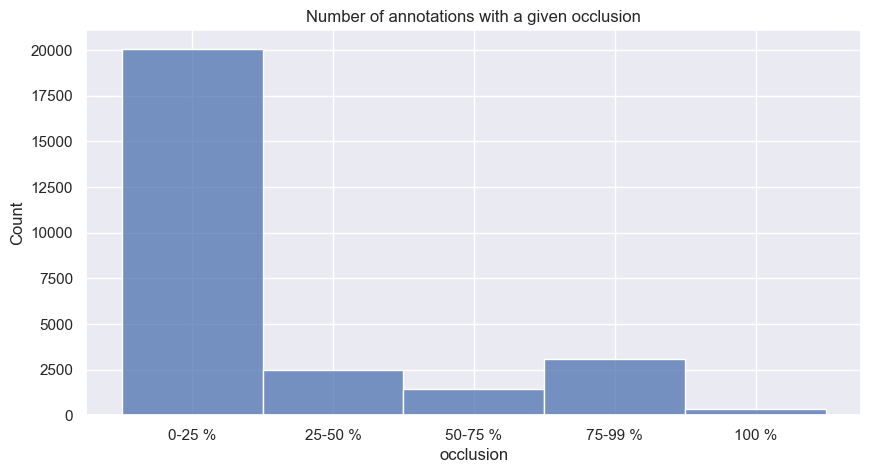

In [91]:
sns.set(rc={"figure.figsize": (10, 5)})


df_temp = df
df_temp["occlusion"] = pd.Categorical(
    df_temp["occlusion"], ["0-25 %", "25-50 %", "50-75 %", "75-99 %", "100 %"]
)

_ = sns.histplot(df_temp["occlusion"]).set(
    title="Number of annotations with a given occlusion"
)

df_temp["occlusion"].value_counts()

The mentioned 320 images can be found in 196 images.

In [92]:
df_temp = df[df["occlusion"] == "100 %"][["path", "label_uid", "sensor"]]
len(df_temp)

320

In [93]:
# images with at least 1 100% occlusion track
len(df_temp["path"].drop_duplicates())

196

Sensors pointing to the left feature less covered labels. Yet, there are also less images in that category. 

C:\Users\atkovacs\AppData\Local\Temp\ipykernel_5148\4129478246.py:2: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



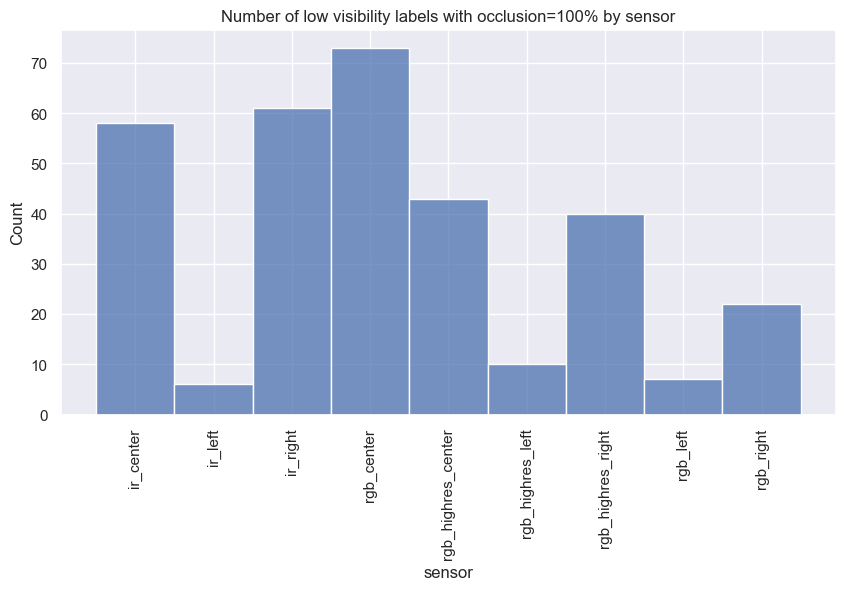

In [94]:
p = sns.histplot(df_temp.sort_values("sensor"), x="sensor")
p = p.set_xticklabels(p.get_xticklabels(), rotation=90)
plt.title("Number of low visibility labels with occlusion=100% by sensor")
plt.show()

#### Examples of images/labels with occlusion = 100%

5_station_bergedorf_5.1/ir_center/071_1631529900.200464440.png


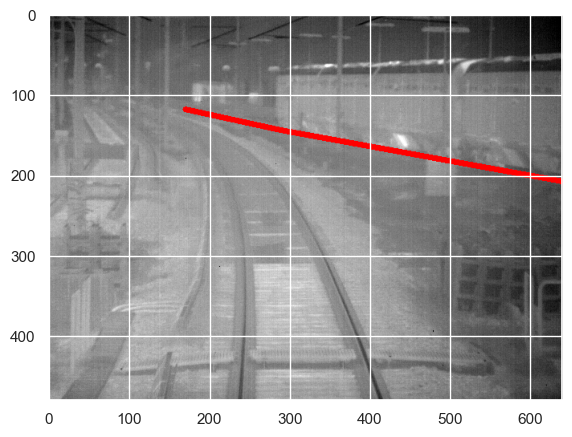

In [95]:
path = df_temp.iloc[54]["path"]
uid = df_temp.iloc[54]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

5_station_bergedorf_5.1/rgb_highres_center/099_1631529903.000000025.png


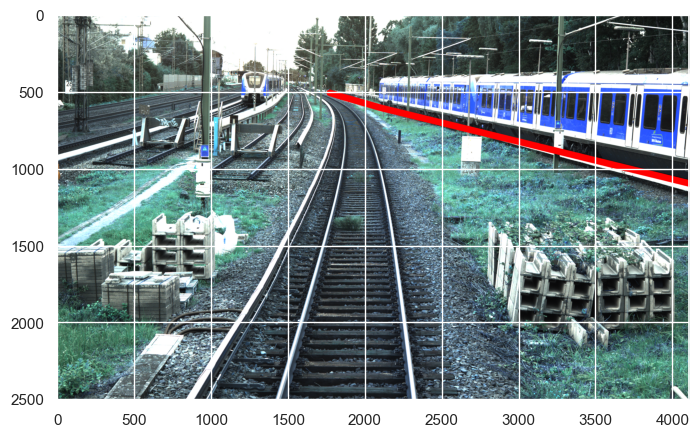

In [112]:
path = df_temp.iloc[-10]["path"]
uid = df_temp.iloc[-10]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

18_vegetation_switch_18.1/rgb_center/079_1631625169.000000040.png


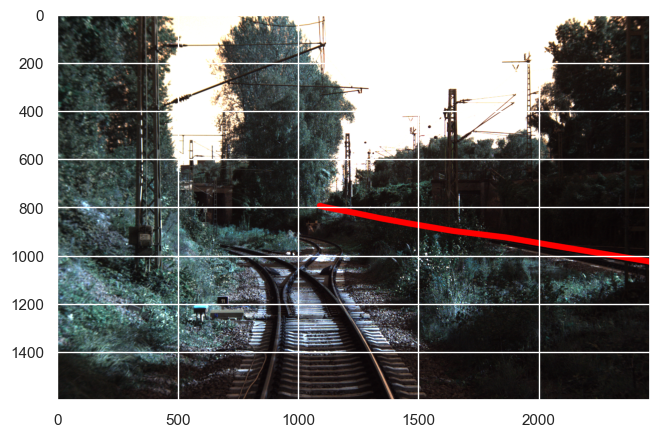

In [96]:
path = df_temp[df_temp["sensor"] == "rgb_center"].iloc[10]["path"]
uid = df_temp[df_temp["sensor"] == "rgb_center"].iloc[10]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

We decide to keep these images in the dataset as many of the coverd labels might be detected anyway and because most images have visible labels as well.

### Images as part of videos

Images are frames from videos. As such the variation between the images is low - especially when the train is not moving.
This is importat to keep in mind when generating train, validation, and test sets (e.g. the accuracy of the model might be distorted with model is trained, validated, and tested on images with minimal differences)

In [77]:
li = EasyImageList.from_folder("./orig_data/DB/3_fire_site_3.3/rgb_highres_center/")
li.html(size=200)

In [78]:
li = EasyImageList.from_folder("./orig_data/DB/3_fire_site_3.4/rgb_highres_center/")
li.html(size=200)

In [79]:
li = EasyImageList.from_folder(
    "./orig_data/DB/4_station_pedestrian_bridge_4.1/rgb_highres_center/"
)
li.html(size=200)

In [80]:
df.to_json(
    f"./dataframe_dumps/df_eda_{datetime.now().strftime('%m-%d-%Y_%H-%M-%S')}.json"
)

In [ ]:
image = cv2.imread(f"./orig_data/{path}")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

rho = 0.3  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 20  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(image) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(
    edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap
)

for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 5)

lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)
plt.imshow(lines_edges)
plt.show()

In [ ]:
image = cv2.imread(
    f"./orig_data/15_construction_vehicle_15.1/rgb_highres_center/069_1631531288.000000005.png"
)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel_size = 15
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

rho = 0.3  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 50  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(image) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(
    edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap
)

for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 20)

lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)
plt.imshow(lines_edges)
plt.show()